# Predicting with CNN Model
# Model 4.0 
# Real TEM training data
# Full-sized synthetic & TEM images (+ watershed algorithm)
#### Ross Carmichael
#### 19/10/21

In [10]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import cv2
from MightyMosaic import MightyMosaic

from scipy import ndimage as ndi

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [15]:
model = tf.keras.models.load_model('./saved_model/model_4.0_100_epochs.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

# Load in some images to be segmented

In [38]:
def load_data(path, tif=False):
    if tif:
        images = sorted(glob(os.path.join(path, "*.tif")))
        return images
    else:
        images = sorted(glob(os.path.join(path, "*.png")))
        return images

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = image / 255.0
    image = image.astype(np.float32)

    return image

# Predict TEM image

In [39]:
path = "../preprocessing/_data/augmented/particles/"

# File paths
images = load_data(path, tif=False)
print(f"Images: {len(images)}")

tem_images = [read_image(image) for image in images[:5]]
print(images[0], tem_images[0].shape)

tem_images = [1-img for img in tem_images]

Images: 4096
../preprocessing/_data/augmented/particles/augmented_image_1.png (128, 128, 3)


In [40]:
path = "../full-size/tem/"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

tem_images = [read_image(image) for image in images]
print(images[0], tem_images[0].shape)

tem_images = [1-img for img in tem_images]

Images: 8
../full-size/tem/ASM306_grayscale_0000.tif (4096, 4096, 3)


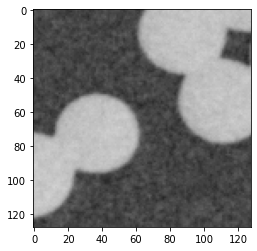

In [19]:
plt.imshow(tem_images[0])

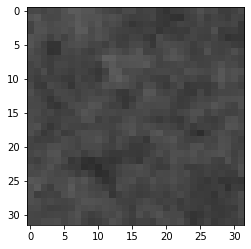

In [36]:
M,N = 32,32
im=tem_images[0]
tiles = [im[x:x+M, y:y+N] for x in range(0, im.shape[0], M) for y in range(0, im.shape[1], N)]

In [31]:
print(tem_images[0].shape)
pred = model.predict(np.expand_dims(tem_images[0], axis=-1))

(128, 128, 3)


ValueError: in user code:

    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/ross/opt/anaconda3/envs/cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 128, 128, 3), found shape=(32, 128, 3, 1)


In [23]:
labels = np.argmax(pred[0], axis=-1)    
print(np.unique(labels))
plt.figure(figsize=(8,8))
plt.imshow(labels)
plt.show()

NameError: name 'pred' is not defined

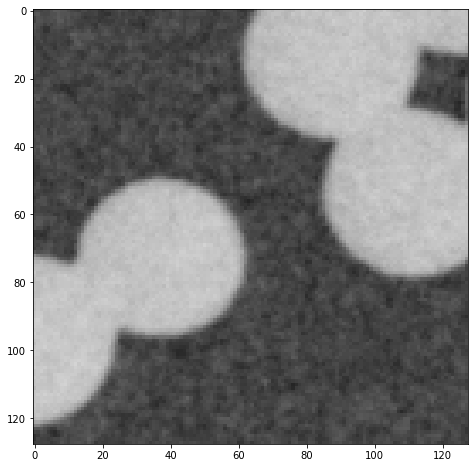

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(tem_images[0])
plt.show()

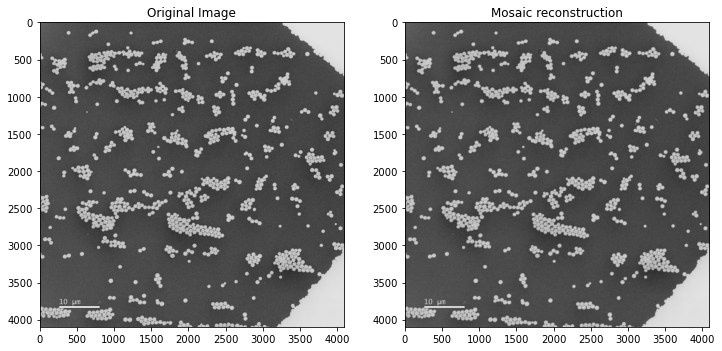

Mosaic shape: (64, 64, 128, 128, 3)


In [41]:
mosaic2 = MightyMosaic.from_array(tem_images[0], (128,128), overlap_factor=2, fill_mode='reflect')
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(tem_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic2.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic2.shape))

In [43]:
prediction2 = mosaic2.apply(model.predict, progress_bar=True)

  0%|          | 0/4096 [00:00<?, ?it/s]

In [44]:
fused_prediction2 = prediction2.get_fusion()
labels2 = np.argmax(fused_prediction2, axis=-1)

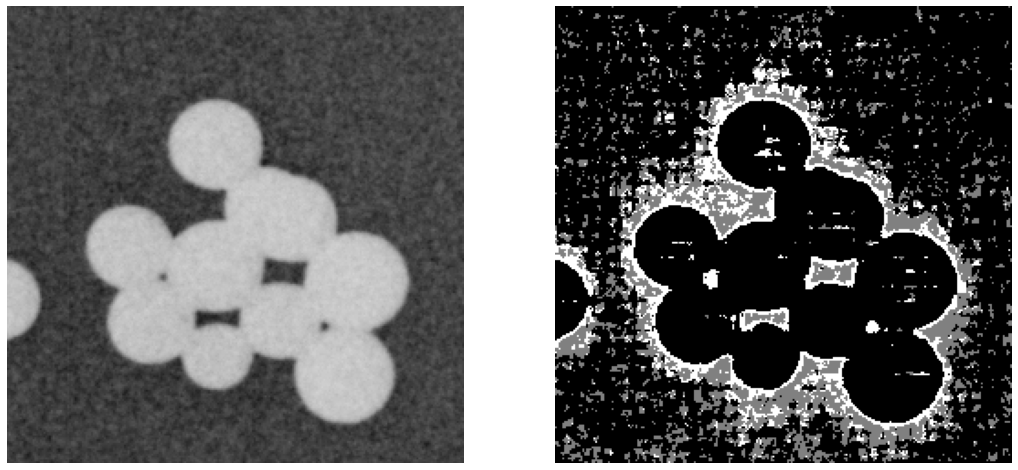

In [53]:
fig, axs = plt.subplots(1,2, figsize=(18,18))

axs[0].imshow(tem_images[0][750:1000,1500:1750])
axs[0].axis('off')
axs[1].imshow(labels2[750:1000,1500:1750], cmap=plt.cm.gray)
axs[1].axis('off')


name = os.path.split(images[0])[-1]
#cv2.imwrite("segmented_" + name[:-4] + ".tif", labels2*127)
plt.savefig("model4_segmentation.pdf")
plt.show()

# Apply the watershed algorithm 

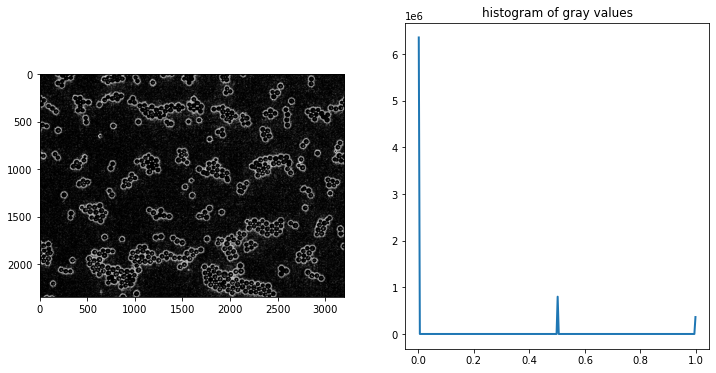

In [19]:
from skimage.exposure import histogram

# Crop to remove the sample plate
img = labels2[550:2900, :3200]/2#[2500:2900:,1600:2500]/2
hist, hist_centers = histogram(img)   # generate histogram data for cropped image

fig, axes = plt.subplots(1, 2, figsize=(12, 6))   # create figure with two sub-plots
axes[0].imshow(img, cmap=plt.cm.gray)   # display cropped image
axes[0].axis('on')
axes[1].plot(hist_centers, hist, lw=2)   # plot histogram
axes[1].set_title('histogram of gray values')
plt.show()

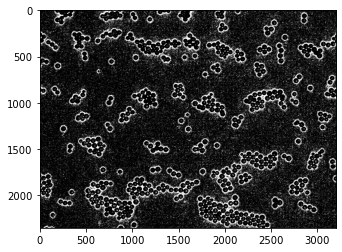

In [20]:
img[img==0.5] = 1
plt.figure(figsize=(8,4))
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

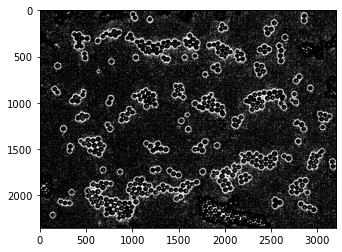

In [21]:
# Area opening removes all bright structures of an image with a surface smaller than area_threshold.
# Clear border remves objects touching the border of the image
#from skimage.morphology import area_opening()
from skimage.segmentation import clear_border
img = clear_border(img)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

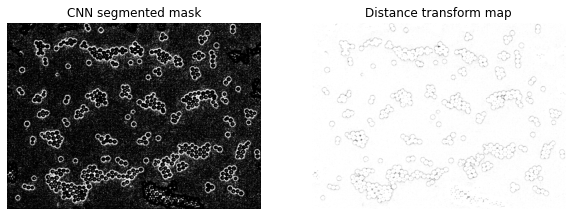

In [22]:
# turn objects into catchment basin using a distance map
dis = ndi.distance_transform_edt(img)
ndis = -dis

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # create figure with two sub-plots
axes[0].set_title('CNN segmented mask')
axes[0].imshow(img, cmap=plt.cm.gray)   # display binary image
axes[0].axis('off')
axes[1].set_title('Distance transform map')
axes[1].imshow(ndis, cmap=plt.cm.gray)   # display distance image
axes[1].axis('off')
plt.show()

In [23]:
# generate markers as local maxima in distance map
from skimage.feature import peak_local_max
locedge = 3
locreg  = np.ones((locedge, locedge))
locmax  = peak_local_max(dis, min_distance=25)   # particle centres near local maxima in distance map of eroded image

mask = np.zeros(dis.shape, dtype=bool)   # set up mask with same shape as distance map and pre-populate with False
mask[tuple(locmax.T)] = True   # set mask to True at coordinates of local maxima
markers, num_markers = ndi.label(mask, structure=None,)   # labels objects in mask, False or 0 is considered background
print("Number of markers     = {}".format(num_markers))

Number of markers     = 3173


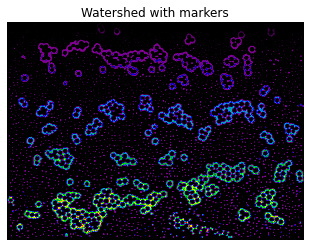

In [24]:
# now do watershed with markers
from skimage.segmentation import watershed
marker_watershed = watershed(ndis, markers=markers, mask=img, watershed_line=True)   # watershed and label image

fig, ax = plt.subplots(figsize=(10, 4))  
ax.set_title('Watershed with markers')
ax.imshow(marker_watershed, cmap=plt.cm.nipy_spectral)   
ax.axis('off')
plt.show()

In [25]:
# get region properties
from skimage.measure import regionprops
regprop = regionprops(marker_watershed)

# Loop through regprop and append area of each labeled object to list.
particles = []
cutoff_area = 500

for i in range(len(regprop)):
    area = regprop[i].area
    if area < cutoff_area:
        continue
    yc   = regprop[i].centroid[0]
    xc   = regprop[i].centroid[1]
    
    particles.append([yc,xc,area])

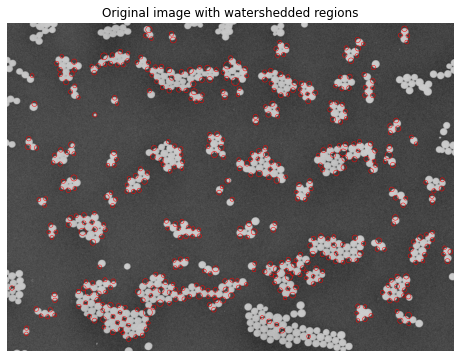

In [27]:
# check whether correct particles found by drawing particle centers
from matplotlib.patches import Circle
from math import sqrt, pi

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1, figsize=(8,8))
ax.set_aspect('equal')

# Show the image
ax.imshow(tem_images[0][550:2900, :3200], cmap=plt.cm.gray)
ax.set_title('Original image with watershedded regions')

# Now, loop through coord arrays, and create a circle at each x,y pair
rr = 1
for item in particles:
    area=item[2]
    xc = item[1]
    yc = item[0]
    rr = sqrt(item[2]/pi)
    circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',fill=False,linewidth=0.5)
    ax.add_patch(circ)

    # Show the image
plt.axis('off')
plt.savefig("model_3.0_" + name[:-4] + ".svg")
plt.show()

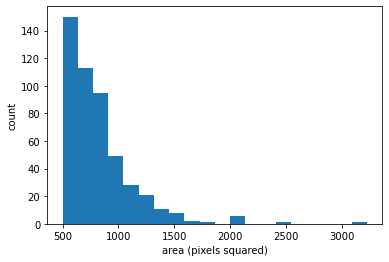

In [28]:
# plot histogram of radii
areas = []
for item in particles:
    area = item[2]
    areas.append(area)

# plot image histogram
areas_array = np.array(areas)

plt.hist(areas_array,bins=20)
plt.xlabel("area (pixels squared)")
plt.ylabel("count")
plt.savefig("s_distrbn_model_3.0.png")
plt.show()

# Run all TEM images through 

In [15]:
# for i, tem_image in enumerate(tem_images):
#     print(str(i+1) + ' of ' + str(len(tem_images)))
    
#     # Mosaic and predict
#     mosaic = MightyMosaic.from_array(tem_image, (128,128), overlap_factor=2, fill_mode='reflect')
#     prediction = mosaic.apply(model.predict, progress_bar=True)
    
#     clear_output()
    
#     # Fuse and get labels
#     fused_prediction = prediction.get_fusion()
#     labels = np.argmax(fused_prediction, axis=-1)

#     name = os.path.split(images[i])[-1]
    
#     cv2.imwrite("segmented_" + name[:-4] + ".tif", labels*127)

# Run an SEM image through prediction

In [35]:
path = "../full-size/sem/coated"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

sem_images = [read_image(image) for image in images]
print(sem_images[0].shape)

sem_images = [1-img for img in sem_images]

Images: 2
(960, 1280, 3)


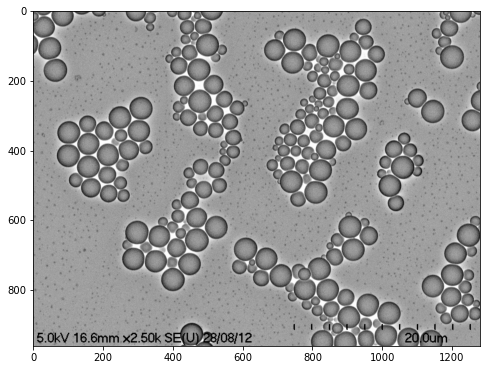

In [36]:
plt.figure(figsize=(8,8))
plt.imshow(sem_images[0])
plt.show()

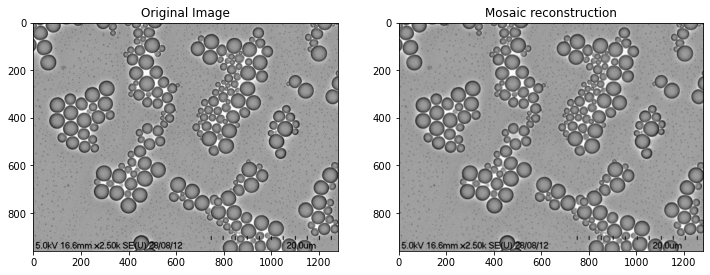

Mosaic shape: (16, 20, 128, 128, 3)


In [37]:
mosaic3 = MightyMosaic.from_array(sem_images[0], (128,128), overlap_factor=2, fill_mode='reflect')
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(sem_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic3.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic3.shape))

In [38]:
prediction3 = mosaic3.apply(model.predict, progress_bar=True)

In [39]:
fused_prediction3 = prediction3.get_fusion()
labels3 = np.argmax(fused_prediction3, axis=-1)

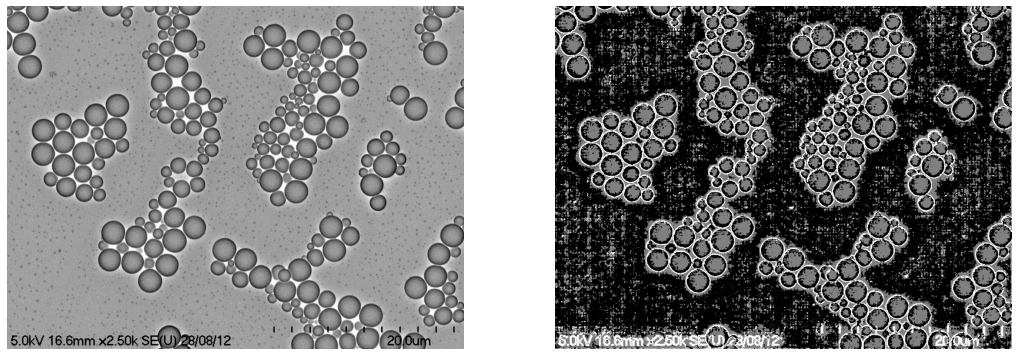

In [40]:
fig, axs = plt.subplots(1,2, figsize=(18,18))

axs[0].imshow(sem_images[0])
axs[0].axis('off')
axs[1].imshow(labels3, cmap=plt.cm.gray)
axs[1].axis('off')

name = os.path.split(images[0])[-1]
cv2.imwrite("segmented_" + name[:-4] + ".tif", labels3*127)
plt.show()